# PyTorch Layer 이해하기

# 예제 불러오기

In [1]:
import torch
from torchvision import datasets, transforms

In [2]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
# batch_size는 가지고 올 데이터 갯수를 의미

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('dataset', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor()
                   ])),
    batch_size=1)

In [4]:
image, label = next(iter(train_loader))

In [5]:
image.shape

torch.Size([1, 1, 28, 28])

In [6]:
# 배치사이즈와 채널정보를 제거 (squeeze)
torch_image = torch.squeeze(image)
torch_image.shape

torch.Size([28, 28])

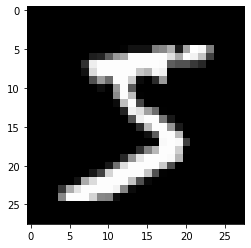

In [7]:
plt.imshow(torch_image,'gray')
plt.show()

# 각 Layer별 설명

- Network 쌓기 위한 준비

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

### Convolution

- in_channels: 받게 될 channel의 갯수
- out_channels: 보내고 싶은 channel의 갯수  
- kernel_size: 만들고 싶은 kernel(weights)의 사이즈

In [9]:
# 컨볼루션
nn.Conv2d(in_channels=1, out_channels=20, kernel_size=5, stride=1).to(torch.device('cpu'))

Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))

In [10]:
layer = nn.Conv2d(1,20,5,1).to(torch.device('cpu'))
layer

Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))

- weight 시각화를 위해 slice하고 numpy화

In [11]:
weight = layer.weight
weight.shape

torch.Size([20, 1, 5, 5])

- 여기서 weight는 학습 가능한 상태이기 때문에 바로 numpy로 뽑아낼 수 없음
- detach() method는 그래프에서 잠깐 빼서 gradient에 영향을 받지 않게 함

In [12]:
# detach()는 gradient에 영향을 받지 않게 함
# detach()가 없으면 오류
weight = weight.detach().numpy()
weight.shape

(20, 1, 5, 5)

In [13]:
weight_ = np.squeeze(weight)
weight_.shape

(20, 5, 5)

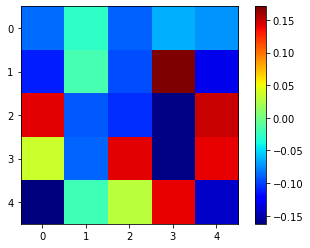

In [14]:
plt.imshow(weight[0,0,:,:],'jet')
plt.colorbar()
plt.show()

- output 시각화 준비를 위해 numpy화

In [15]:
output = layer(image)

In [16]:
# 데이터 확인
output_data = output.data

In [17]:
output_ = output_data.cpu().numpy()

In [18]:
output_.shape

(1, 20, 24, 24)

- Input으로 들어간 이미지 numpy화 

In [19]:
image_arr = image.numpy()
image_arr.shape

(1, 1, 28, 28)

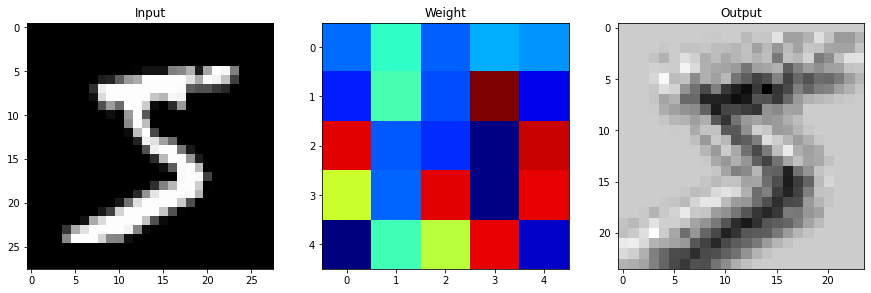

In [20]:
# .squeeze는 배열에서 1만 제거

plt.figure(figsize=(15,30))
plt.subplot(131)
plt.title('Input')
plt.imshow(np.squeeze(image_arr),'gray')

plt.subplot(132)
plt.title('Weight')
plt.imshow(weight[0,0,:,:],'jet')

plt.subplot(133)
plt.title('Output')
plt.imshow(output_[0,0,:,:],'gray')

plt.show()

### Pooling

input을 먼저 앞에 넣고, 뒤에 kernel 사이즈와 stride를 순서대로 넣음

In [21]:
image.shape

torch.Size([1, 1, 28, 28])

In [22]:
# 풀링하면 반으로 줄어든것을 확인

pool = F.max_pool2d(image,2,2)
pool.shape

torch.Size([1, 1, 14, 14])

- MaxPool Layer는 weight가 없기 때문에 바로 numpy()가 가능

In [23]:
pool_arr = pool.numpy()
pool_arr.shape

(1, 1, 14, 14)

In [24]:
image_arr.shape

(1, 1, 28, 28)

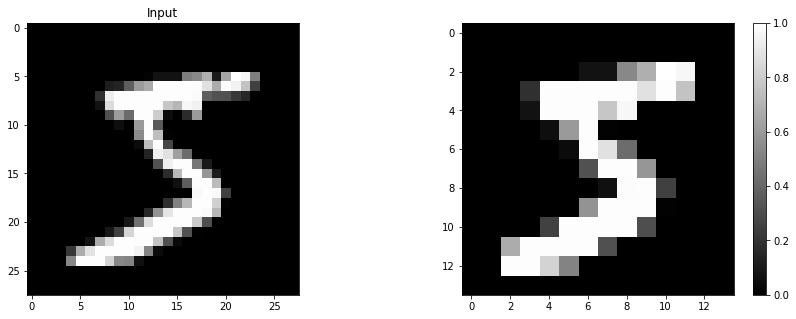

In [25]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.title('Input')
plt.imshow(np.squeeze(image_arr), 'gray') 

plt.subplot(1,2,2)
plt.imshow(np.squeeze(pool_arr),'gray')
plt.colorbar()
plt.show()

### Linear

nn.Linear는 2d가 아닌 1d만 들어가기 때문에 .view() 1D로 펼쳐줘야함

In [26]:
flatten = image.view(1, 28*28)
flatten.size()[1]

784

In [27]:
# 10개로 내보냄
lin = nn.Linear(flatten.size()[1], 10)(flatten)
lin.shape

torch.Size([1, 10])

In [28]:
lin

tensor([[ 0.0697, -0.0437, -0.3028, -0.1543, -0.0238, -0.0943,  0.0370, -0.2448,
         -0.1488,  0.0416]], grad_fn=<AddmmBackward>)

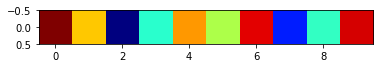

In [29]:
# weight가 있는경우 .detach()
# 제일 높은값이 5번쨰 낮은값은 8번쨰에 있음

plt.imshow(lin.detach().numpy(),'jet')
plt.show()

### Softmax

결과를 numpy로 꺼내기 위해선 weight가 담긴 Linear에 weight를 꺼줘야함

In [30]:
# no_grad를 하지않으면 softmax를 볼수 없음
with torch.no_grad():
    flatten = image.view(1, 28*28)
    lin = nn.Linear(flatten.size()[1], 10)(flatten)
    softmax = F.softmax(lin,dim=1)

In [31]:
softmax

tensor([[0.1095, 0.0995, 0.0716, 0.1104, 0.0825, 0.1310, 0.0661, 0.1408, 0.0918,
         0.0968]])

In [32]:
np.sum(softmax.numpy())

1.0000001

# Layer 쌓기

예제 출처: https://pytorch.org/tutorials/beginner/pytorch_with_examples.html#id23

nn 과 nn.functional의 차이점
- nn은 학습 파라미터가 담긴 것 
- nn.functional은 학습 파라미터가 없는 것이라 생각하면 간단

In [85]:
class Net(nn.Module):
    '''
    클래스
    '''
    def __init__(self):
        super(Net,self).__init__()
        self.conv1 = nn.Conv2d(1,20,5,1)
        self.conv2 = nn.Conv2d(20,50,5,1) 
        self.fc1 = nn.Linear(4*4*50,500) 
        self.fc2 = nn.Linear(500,10) 

    # Feature Extraction
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x,2,2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x,2,2)

        # Fully Connected(Classficiation)
        x = x.view(-1,4*4*50)
        x = F.relu(self.fc1(x))
        x= self.fc2(x)
        
        return F.log_softmax(x, dim=1)


- Image를 Model에 넣어서 결과 확인

In [86]:
model = Net()

In [87]:
result = model.forward(image)
result

tensor([[-2.2445, -2.2107, -2.1846, -2.3554, -2.3453, -2.3242, -2.3655, -2.3594,
         -2.3665, -2.2912]], grad_fn=<LogSoftmaxBackward>)

In [88]:
Net.__doc__

'\n    클래스\n    '